![Logo TUBAF](https://tu-freiberg.de/sites/default/files/media/freiberger-alumni-netzwerk-6127/wbm_orig_rgb_0.jpg)

Exercise material of the MSc-level course **Numerical Methods in Geotechnical Engineering**.
Held at Technische Universität Bergakademie Freiberg.

Comments to:

*Prof. Dr. Thomas Nagel  
Chair of Soil Mechanics and Foundation Engineering  
Geotechnical Institute  
Technische Universität Bergakademie Freiberg.*

https://tu-freiberg.de/en/soilmechanics


In [318]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

#Some plot settings
import plot_functions.plot_settings

In [319]:
#element class
class quad4_element():#local coordinates go from -1 to 1
    #takes global nodal coordinates, global node ids
    def __init__(self, ncoords=[[0.,0.],[1.,0.],[1.,1.],[0.,1.]], nids=[0,1,2,3]):
        self.__nnodes = 4
        if (len(ncoords) != self.__nnodes):
            raise Exception("Number of coordinates does not match number \
                            of nodes of element (%i vs of %i)" %(self.__nnodes,len(ncoords)))
        else:
            self.__coords = np.array(ncoords)
        
        self.__natural_coords = np.array([[-1.,-1.],[1.,-1.],[1.,1.],[-1.,1.]])
        
        if (len(nids) != self.__nnodes):
            raise Exception("Number of node IDs does not match number \
                            of nodes of element (%i vs of %i)" %(self.__nnodes,len(nids)))
        else:
            self.__global_ids = np.array(nids)
        self.__quad_degree = 2
        self.__quad_points, self.__quad_weights = np.polynomial.legendre.leggauss(self.__quad_degree)
    
    def get_centroid(self):
        return [np.mean(self.__coords[:,0]),np.mean(self.__coords[:,1])]

Next, we wish to generate a one-dimensional mesh by specifying the length of a line, the number of elements into which the mesh is to be split, and the number of nodes per element.

In [320]:
#quadratic elements
dx = 2.
dy = 2.
node_list = np.array([[0.0,0.0]]*9)
for i in range(len(node_list)):
    node_list[i][0] = int(i/3)*dx
    node_list[i][1] = (i%3)*dy

connectivity = [[0,3,4,1],[1,4,5,2],[3,6,7,4],[4,7,8,5]]
element_vector = []
for i in range(len(connectivity)):
    element_vector.append(quad4_element([node_list[connectivity[i][0]],
                                         node_list[connectivity[i][1]],
                                         node_list[connectivity[i][2]],
                                         node_list[connectivity[i][3]]],
                                        connectivity[i]))
solution = np.array([0.]*len(node_list))

Let's plot the mesh.

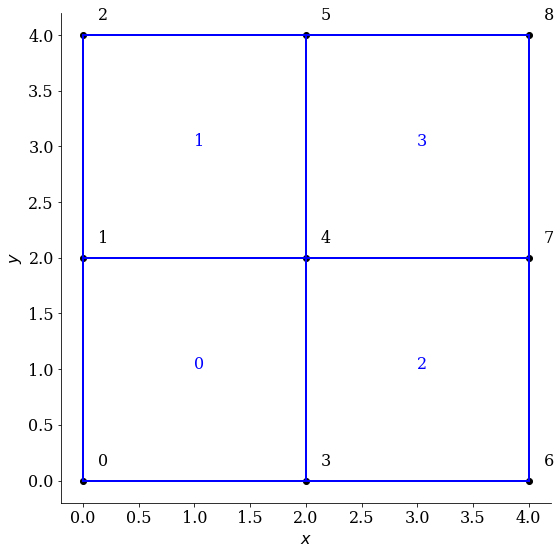

In [321]:
fig, ax = plt.subplots()
for i in range(len(node_list)):
    ax.plot(node_list[i][0],node_list[i][1],color='black',marker='o')
    ax.text(node_list[i][0]+dx/15,node_list[i][1]+dy/15,'%i' %i)
for ne,e in enumerate(element_vector):
    e_coords = e._quad4_element__coords
    for i in range(len(e_coords)):
        ax.plot([e_coords[i-1,0],e_coords[i,0]],[e_coords[i-1,1],e_coords[i,1]],color='blue')
    ax.text(e.get_centroid()[0],e.get_centroid()[1],'%i' %ne, color='blue')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_aspect('equal')
fig.tight_layout();

## Bilinear shape functions in 2D


Linear elements have two nodes with $\xi_1 = -1$ and $\xi_2 = 1$. The linear shape functions are

\begin{align}
    N_1(\xi,\eta) &= \frac{1}{4} (1-\xi)(1-\eta) \\
    N_2(\xi,\eta) &= \frac{1}{4} (1+\xi)(1-\eta) \\
    N_3(\xi,\eta) &= \frac{1}{4} (1+\xi)(1+\eta) \\
    N_4(\xi,\eta) &= \frac{1}{4} (1-\xi)(1+\eta)
\end{align}

Their gradients in natural coordinates follow as

\begin{align}
    \frac{\text{d} N_1}{\text{d}\xi} &= - \frac{1}{4} (1-\eta) \qquad \frac{\text{d} N_1}{\text{d}\eta} = - \frac{1}{4} (1-\xi) \\
    \frac{\text{d} N_2}{\text{d}\xi} &= + \frac{1}{4} (1-\eta) \qquad \frac{\text{d} N_2}{\text{d}\eta} = - \frac{1}{4} (1+\xi) \\
    \frac{\text{d} N_3}{\text{d}\xi} &= + \frac{1}{4} (1+\eta) \qquad \frac{\text{d} N_3}{\text{d}\eta} = + \frac{1}{4} (1+\xi) \\
    \frac{\text{d} N_4}{\text{d}\xi} &= - \frac{1}{4} (1+\eta) \qquad \frac{\text{d} N_4}{\text{d}\eta} = + \frac{1}{4} (1-\xi)
\end{align}

### Jacobians and gradients

An unknown is approximated as $u \approx N_i \hat{u}_i$ where $i$ runs over all nodes of a given element and $\hat{u}_i$ are the nodal degrees of freedom. To peform a gradient calculation (here in 1D) 

$$
    \text{grad} u = \frac{\text{d} u}{\text{d} x_k} = \frac{\text{d}N_i}{\text{d} x_k} \hat{u}_i = \frac{\text{d}N_i}{\text{d} \xi_j} \frac{\text{d}\xi_j}{\text{d} x_k} \hat{u}_i = \frac{\text{d}N_i}{\text{d} \xi_j} J_{jk}^{-1} \hat{u}_i
$$

The element Jacobian follows from the isoparametric coordinate approximation $x_k \approx N_i \hat{x}_k^i$ where $\hat{x}_k^i$ are the nodal coordinates in the $k$ direction:

$$
    J_{jk} = \frac{\text{d} x_j}{\text{d}\xi_k} = \frac{\text{d} N_i}{\text{d}\xi_k} \hat{x}_j^i
$$

We use the following shorthand:

$$
    \nabla N_{ij} = \frac{\text{d}N_i}{\text{d} x_j} = \frac{\text{d}N_i}{\text{d} \xi_k} J_{kj}^{-1}
$$

In [322]:
#N
def shape_function(xi,eta):
    return np.array([(1-xi)*(1-eta),
                     (1+xi)*(1-eta),
                     (1+xi)*(1+eta),
                     (1-xi)*(1+eta)])/4.
#dN_dxi
def dshape_function_dxi(xi,eta):
    return np.array([[-(1-eta), -(1-xi)],
                     [+(1-eta), -(1+xi)],
                     [+(1+eta), +(1+xi)],
                     [-(1+eta), +(1-xi)]])/4.

    
#untested
def element_jacobian(xi,eta,element):
    Jacobian = np.dot(dshape_function_dxi(xi,eta).T,element._quad4_element__coords)
    #Jacobian += dshape_function_dxi(element_order,xi).dot(element._line_element__coords)
    return Jacobian

#untested
def grad_shape_function(xi,eta,element):
    Jac = element_jacobian(xi,eta,element)
    return np.dot(dshape_function_dxi(xi,eta),np.linalg.inv(Jac))

In [323]:
def test_gradN(xi,eta):
    dNdX = dshape_function_dxi(xi,eta)
    dNdX_num1 = (shape_function(xi+1e-8,eta) - shape_function(xi-1e-8,eta))/2e-8
    dNdX_num2 = (shape_function(xi,eta+1e-8) - shape_function(xi,eta-1e-8))/2e-8
    dNdX_num = np.array([dNdX_num1,dNdX_num2]).T
    return np.max(dNdX_num-dNdX)

In [324]:
xis = np.linspace(-1,1,10)
for x in xis:
    for y in xis:
        if (test_gradN(x,y) >1e-8):
            print("ERROR")

Now let's plot the shape functions to see if they were implemented correctly.

In [325]:
def plot_shape_functions():
    x = np.linspace(-1.,1.,10)
    y = np.copy(x)
    X, Y = np.meshgrid(x,y)
    #print(X,Y)
    h = shape_function(X,Y)
    fig = plt.figure(figsize=(20,5))
    corners = [[-1.,-1.],[1.,-1.],[1.,1.],[-1.,1.]]
    for i in range(4):
        #ax[i] = ax[i].add_subplot(111, projection='3d')
        ax = fig.add_subplot(1, 4, 1+i, projection='3d')
        ax.plot_surface(X,Y,h[i])
        ax.set_xlabel('$\\xi$')
        ax.set_ylabel('$\\eta$')
        ax.set_zlabel('$N_{%i}$' %(i+1))
        ax.plot(corners[i][0],corners[i][1],0,marker='o',color='r')
    fig.tight_layout();

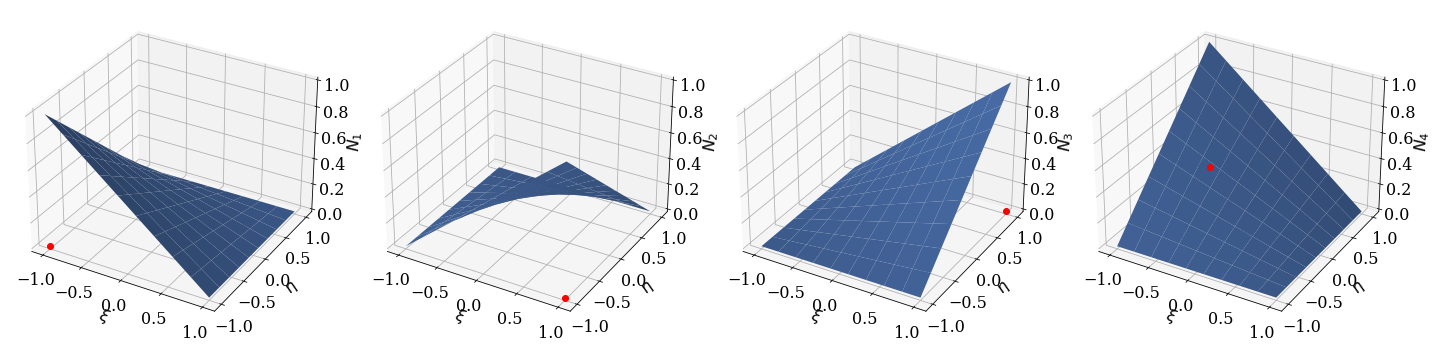

In [326]:
plot_shape_functions()

## Potential flow

PDE:

$$
    0 = q_{i,i} \quad \text{with} \quad q_i = - \frac{k_{ij}}{\mu} p_{,j}
$$

so that

$$
    0 = \left(\frac{k_{ij}}{\mu} p_{,j}\right)_{,i}
$$

Weak form:

\begin{align}
    0 &= \int \limits_\Omega v q_{i,i} \,\text{d}\Omega = \int \limits_{\partial \Omega_q} v q_\text{out} \,\text{d}\Gamma - \int \limits_\Omega v_{,i} q_i \,\text{d}\Omega
    \\
    0 &= \int \limits_\Omega v_{,i} \frac{k_{ij}}{\mu} p_{,j} \,\text{d}\Omega - \int \limits_{\partial \Omega_q} v q_\text{in} \,\text{d}\Gamma
\end{align}

Discretized form ($k$ equations):

$$
    0 = \int \limits_\Omega \nabla N_{ik} \frac{k_{ij}}{\mu} \nabla N_{jl} \,\text{d}\Omega\ \hat{p}_l - \int \limits_{\partial \Omega_q} N_k q_\text{in} \,\text{d}\Gamma
$$

and elementwise:

$$
    0 = \bigcup \limits_{e=1}^{n_\text{el}} \int \limits_\Omega \nabla N_{ik} \frac{k_{ij}}{\mu} \nabla N_{jl}\,\det J \,\text{d}\Omega_e\ \hat{p}_l - \bigcup \limits_{e=1}^{n_\text{el}^q} \int \limits_{\partial \Omega_{e,q}} N_k q_\text{in} \det J_\Gamma \,\text{d}\Gamma_e
$$

What we require now is the local assembler to calculate the stiffness matrix and the local right-hand side. Local integration is performed by Gauss quadrature:

$$
    \int \limits_{-1}^1 \int \limits_{-1}^1 f(\xi,\eta)\,\text{d}\xi \,\text{d}\eta \approx \sum \limits_{i=1}^{n_\text{gp}} \sum \limits_{j=1}^{n_\text{gp}} f(\xi_i,\eta_j) w_i w_j 
$$

## Local assember

For now without Neumann boundaries and for isotropy.

In [327]:
def local_assembler(elem):
    K_loc = np.zeros((4,4))
    for i in range(2):
        for j in range(2):
            #local integration point coordinate
            xi = elem._quad4_element__quad_points[i]
            eta = elem._quad4_element__quad_points[j]
            dN_dX = grad_shape_function(xi,eta,elem)
            N = shape_function(xi,eta)
            #determinant of Jacobian
            detJ = np.linalg.det(element_jacobian(xi,eta,elem))
            #integration weight
            w_i = elem._quad4_element__quad_weights[i]
            w_j = elem._quad4_element__quad_weights[j]
            #assembly of local stiffness matrix
            K_loc += np.dot(dN_dX,dN_dX.T) * w_i * w_j * detJ
            #K_loc += np.dot(N,N.T) * w_i * w_j * detJ * 2
            #print(w_i,w_j,detJ)
    #k = 1e-14
    #mu = 1e-3
    
    #K_loc *= k/mu
    return K_loc

In [328]:
local_assembler(element_vector[1])

array([[ 0.66666667, -0.16666667, -0.33333333, -0.16666667],
       [-0.16666667,  0.66666667, -0.16666667, -0.33333333],
       [-0.33333333, -0.16666667,  0.66666667, -0.16666667],
       [-0.16666667, -0.33333333, -0.16666667,  0.66666667]])

## Global assembly

Now we can construct the global matrix system $\mathbf{K}\mathbf{u} = \mathbf{f}$ or $\mathbf{A}\mathbf{x}=\mathbf{b}$ (see lecture script).

In [329]:
def global_assembler(nodes,elements,solution):
    K_glob = np.zeros((len(nodes),len(nodes)))
    b_glob = np.zeros(len(nodes))
    for i,elem in enumerate(elements):
        K_i = local_assembler(elem)
        for n in range(4):
            for n2 in range(4):
                K_glob[elem._quad4_element__global_ids[n],elem._quad4_element__global_ids[n2]] = K_i[n,n2]
    return K_glob, b_glob

## Application of boundary conditions

A Dirichlet boundary condition $\bar{u}$ at node $m$ is introduced into the system $K_{ik} u_k = f_i$ via

$$
    \left(
    \begin{array}{c}
        K_{11} & K_{12} & \dots & K_{1m} & \dots & K_{1n_\text{n}}
        \\
        K_{21} & K_{22} & \dots & K_{2m} & \dots & K_{2n_\text{n}}
        \\
        \vdots & \vdots & \vdots & \vdots & \vdots & \vdots
        \\
        K_{m1}:=0 & K_{m2}:=0 & \dots & K_{mm}:=1 & \dots & K_{mn_\text{n}}:=0
        \\
        \vdots & \vdots & \vdots & \vdots & \vdots & \vdots
        \\
        K_{n_\text{n}1} & K_{n_\text{n}2} & \dots & K_{n_\text{n}m} & \dots & K_{n_\text{n}n_\text{n}}
    \end{array}    
    \right)
    \left(
    \begin{array}{c}
            u_0\\ u_1\\ \vdots\\ u_m \\ \vdots \\ u_{n_\text{n}}
        \end{array}
    \right)
    =
    \left(
    \begin{array}{c}
            F_0\\ F_1\\ \vdots\\ F_m:=\bar{u} \\ \vdots \\ F_{n_\text{n}}
        \end{array}
    \right)
$$

In [330]:
def apply_Dirichlet_bc(K_glob,b_glob,node_id,value):
    K_glob[node_id,:] = 0.# = K_glob[:,node_id] = 0.
    K_glob[node_id,node_id] = 1.
    b_glob[node_id] = value
    return K_glob, b_glob

## Problem solution

We now perform the global assembly, apply a vanishing traction on the top and constrain the displacement at the bottom to zero.

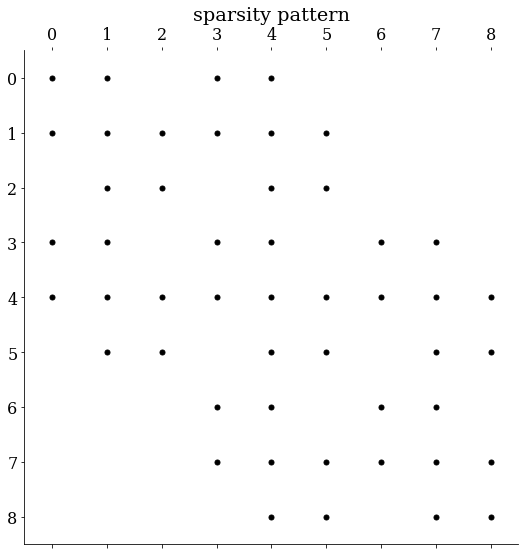

In [331]:
K, f = global_assembler(node_list,element_vector,solution)
plt.spy(K,marker='.')
plt.title('sparsity pattern')
plt.tight_layout()

In [332]:
K

array([[ 0.66666667, -0.16666667,  0.        , -0.16666667, -0.33333333,
         0.        ,  0.        ,  0.        ,  0.        ],
       [-0.16666667,  0.66666667, -0.16666667, -0.33333333, -0.16666667,
        -0.33333333,  0.        ,  0.        ,  0.        ],
       [ 0.        , -0.16666667,  0.66666667,  0.        , -0.33333333,
        -0.16666667,  0.        ,  0.        ,  0.        ],
       [-0.16666667, -0.33333333,  0.        ,  0.66666667, -0.16666667,
         0.        , -0.16666667, -0.33333333,  0.        ],
       [-0.33333333, -0.16666667, -0.33333333, -0.16666667,  0.66666667,
        -0.16666667, -0.33333333, -0.16666667, -0.33333333],
       [ 0.        , -0.33333333, -0.16666667,  0.        , -0.16666667,
         0.66666667,  0.        , -0.33333333, -0.16666667],
       [ 0.        ,  0.        ,  0.        , -0.16666667, -0.33333333,
         0.        ,  0.66666667, -0.16666667,  0.        ],
       [ 0.        ,  0.        ,  0.        , -0.33333333, -0

In [333]:
left = [0,1,2]
right = [6,7,8]
for i in left:
    K, f = apply_Dirichlet_bc(K, f, i, 1)
for i in right:
    K, f = apply_Dirichlet_bc(K, f, i, 1)
print(K)
print(f)

[[ 1.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          1.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          1.          0.          0.          0.
   0.          0.          0.        ]
 [-0.16666667 -0.33333333  0.          0.66666667 -0.16666667  0.
  -0.16666667 -0.33333333  0.        ]
 [-0.33333333 -0.16666667 -0.33333333 -0.16666667  0.66666667 -0.16666667
  -0.33333333 -0.16666667 -0.33333333]
 [ 0.         -0.33333333 -0.16666667  0.         -0.16666667  0.66666667
   0.         -0.33333333 -0.16666667]
 [ 0.          0.          0.          0.          0.          0.
   1.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          1.        ]]
[1. 1. 1. 0. 0. 0. 1. 1. 1.]


In [334]:
solution = np.linalg.solve(K,f)
solution

array([1.        , 1.        , 1.        , 2.42857143, 3.71428571,
       2.42857143, 1.        , 1.        , 1.        ])